In [5]:
from brian2 import *
from scipy import stats

In [3]:
%matplotlib inline

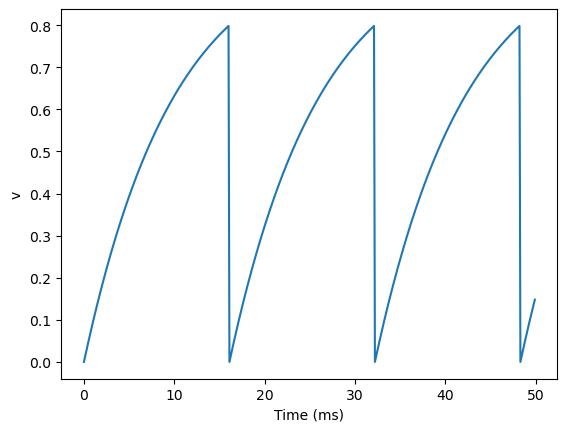

In [11]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

Starting simulation at t=0. s for a duration of 50. ms
50. ms (100%) simulated in 1s
Starting simulation at t=53. ms for a duration of 50. ms
50. ms (100%) simulated in 1s
Velocity = 12.33 m/s


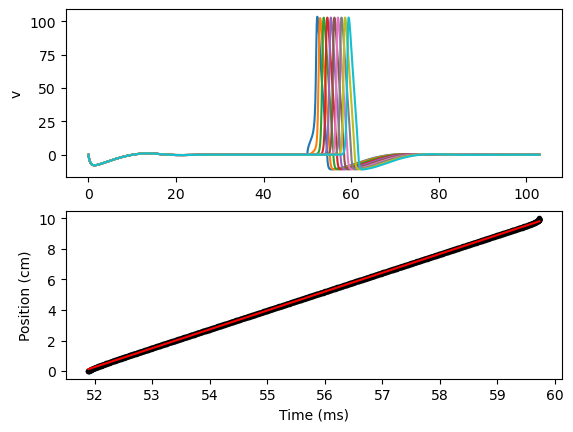

In [6]:
defaultclock.dt = 0.01*ms

morpho = Cylinder(length=10*cm, diameter=2*238*um, n=1000, type='axon')

El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gNa0 = 120*msiemens/cm**2
gK = 36*msiemens/cm**2

# Typical equations
eqs = '''
# The same equations for the whole neuron, but possibly different parameter values
# distributed transmembrane current
Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v) : amp/meter**2
I : amp (point current) # applied current
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * 10*mV/exprel((-v+25*mV)/(10*mV))/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * 10*mV/exprel((-v+10*mV)/(10*mV))/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
gNa : siemens/meter**2
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, method="exponential_euler",
                       refractory="m > 0.4", threshold="m > 0.5",
                       Cm=1*uF/cm**2, Ri=35.4*ohm*cm)
neuron.v = 0*mV
neuron.h = 1
neuron.m = 0
neuron.n = .5
neuron.I = 0*amp
neuron.gNa = gNa0
M = StateMonitor(neuron, 'v', record=True)
spikes = SpikeMonitor(neuron)

run(50*ms, report='text')
neuron.I[0] = 1*uA # current injection at one end
run(3*ms)
neuron.I = 0*amp
run(50*ms, report='text')

# Calculation of velocity
slope, intercept, r_value, p_value, std_err = stats.linregress(spikes.t/second,
                                                neuron.distance[spikes.i]/meter)
print("Velocity = %.2f m/s" % slope)

subplot(211)
for i in range(10):
    plot(M.t/ms, M.v.T[:, i*100]/mV)
ylabel('v')
subplot(212)
plot(spikes.t/ms, spikes.i*neuron.length[0]/cm, '.k')
plot(spikes.t/ms, (intercept+slope*(spikes.t/second))/cm, 'r')
xlabel('Time (ms)')
ylabel('Position (cm)')
show()